### Question 1

Co-adaptation occurs when multiple neurons in a neural network learn to rely on each other to detect specific features. This means that instead of learning independently useful representations, neurons become overly dependent on the presence of specific other neurons. Srivastava et al.'s paper describes this in the context of overfitting; when neurons co-adapt, the network may memorize the training data rather than generalize.

An example of this would be two neurons always firing together only when a certain shape is present in an image. If one neuron fails or is removed (as in dropout), the other cannot detect the feature alone, meaning the network hasn't learned robust features.

Internal covariate shift refers to the change in the distribution of layer inputs during training, as parameters of previous layers change. This makes training unstable and slows convergence because each layer has to constantly adapt to new input distributions. As explained in Ioffe & Szegedy's paper, Batch Normalization addresses this by normalizing the inputs to each layer so they have zero mean and unit variance (based on the current mini-batch). This stabilizes the input distribution, allowing faster and more stable training.


For example, in a deep network, if one layer's output distribution suddenly shifts due to parameter updates, downstream layers would then have to re-learn how to interpret those activations. However, Batch normalization can reduce this shift.

### Question 2

In [29]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Conv2D, AveragePooling2D, Flatten,
                                     Dense, BatchNormalization, Activation)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# normalize input to zero mean, unit variance
mean = x_train.mean()
std = x_train.std()

x_train = (x_train - mean) / std
x_test = (x_test - mean) / std

# reshape for cnn
x_train = x_train[..., tf.newaxis].astype("float32")
x_test = x_test[..., tf.newaxis].astype("float32")

# one-hot encode labels
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)


In [30]:
def build_lenet5():
    model = Sequential()

    model.add(Conv2D(6, kernel_size=(5, 5), padding='same', input_shape=(28, 28, 1)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(AveragePooling2D(pool_size=(2, 2)))

    model.add(Conv2D(16, kernel_size=(5, 5), padding='valid'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(AveragePooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(120))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(Dense(84))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(Dense(10, activation='softmax'))

    return model

In [31]:
model_std = build_lenet5()
model_std.compile(optimizer=tf.keras.optimizers.SGD(), loss='categorical_crossentropy', metrics=['accuracy'])
history_std_input = model_std.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=10, batch_size=128)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 48s 97ms/step - accuracy: 0.7505 - loss: 0.9385 - val_accuracy: 0.9432 - val_loss: 0.2738
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 81s 96ms/step - accuracy: 0.9492 - loss: 0.2298 - val_accuracy: 0.9650 - val_loss: 0.1442
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 45s 96ms/step - accuracy: 0.9660 - loss: 0.1478 - val_accuracy: 0.9740 - val_loss: 0.1101
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 84s 100ms/step - accuracy: 0.9719 - loss: 0.1166 - val_accuracy: 0.9779 - val_loss: 0.0905
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 42s 90ms/step - accuracy: 0.9757 - loss: 0.0978 - val_accuracy: 0.9800 - val_loss: 0.0768
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 85s 95ms/step - accuracy: 0.9781 - loss: 0.0839 - val_accuracy: 0.9823 - val_loss: 0.0700
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 79s 89ms/step - accuracy: 0.9808 - loss: 0.0743 - val_accuracy: 0.9823 - val_loss: 0.0608
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 85s 96ms/step - accuracy: 0.9820 - loss: 0.0684 -

In [32]:
gamma_vals_std = []
beta_vals_std = []

for layer in model_std.layers:
    if isinstance(layer, BatchNormalization):
        gamma, beta, _, _ = layer.get_weights()
        gamma_vals_std.append(gamma)
        beta_vals_std.append(beta)

<ipython-input-33-6af041790217>:5: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_gamma = pd.concat([df_gamma, pd.DataFrame({'Layer': [f'Batch Normalization {i+1}'], 'Gamma': [val]})])


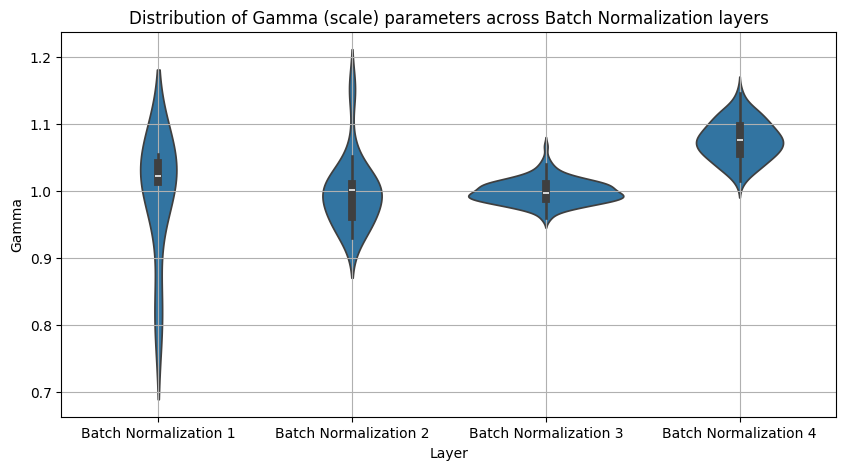

<ipython-input-33-6af041790217>:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_beta = pd.concat([df_beta, pd.DataFrame({'Layer': [f'Batch Normalization {i+1}'], 'Beta': [val]})])


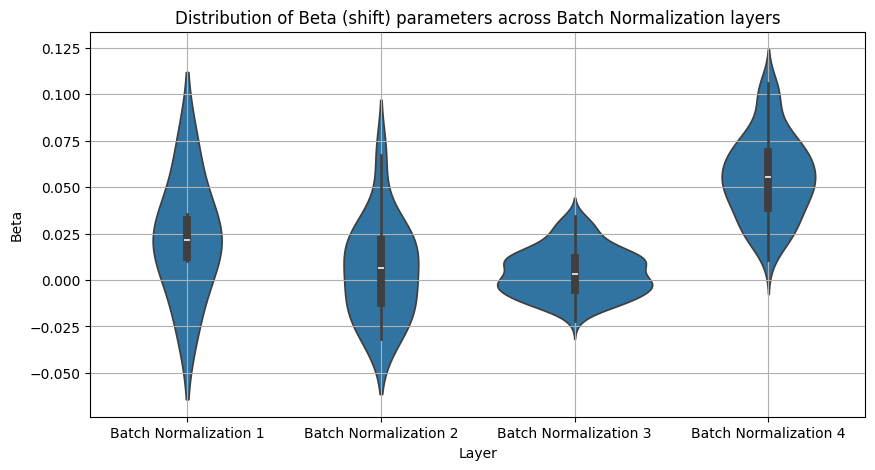

In [33]:
# gamma plot
df_gamma = pd.DataFrame({'Layer': [], 'Gamma': []})
for i, g in enumerate(gamma_vals_std):
    for val in g:
        df_gamma = pd.concat([df_gamma, pd.DataFrame({'Layer': [f'Batch Normalization {i+1}'], 'Gamma': [val]})])

plt.figure(figsize=(10, 5))
sns.violinplot(x='Layer', y='Gamma', data=df_gamma)
plt.title('Distribution of Gamma (scale) parameters across Batch Normalization layers')
plt.grid(True)
plt.show()

# beta plot
df_beta = pd.DataFrame({'Layer': [], 'Beta': []})
for i, b in enumerate(beta_vals_std):
    for val in b:
        df_beta = pd.concat([df_beta, pd.DataFrame({'Layer': [f'Batch Normalization {i+1}'], 'Beta': [val]})])

plt.figure(figsize=(10, 5))
sns.violinplot(x='Layer', y='Beta', data=df_beta)
plt.title('Distribution of Beta (shift) parameters across Batch Normalization layers')
plt.grid(True)
plt.show()


To examine the learned batch normalization parameters, I extracted the gamma (scale) and beta (shift) values from all four batch normalization layers in the LeNet-5 network. These parameters were learned during training and are responsible for normalizing and shifting the activations at each layer.

The gamma parameters across layers tend to cluster around 1, which is expected since gamma maintains the scale of the normalized activations. However, there is some variation between layers. For example, the first and fourth batch normalization layers show slightly wider distributions, suggesting greater flexibility in scaling at those layers, potentially due to more variation in feature distributions at those points.

The beta values mostly center around 0, with relatively narrow distributions. This indicates that the network didn't need to shift the normalized outputs much to optimize performance. The earlier layers show more variability in beta values, which could indicate that it needs to adapt to raw input variations more strongly.

Overall, the gamma and beta distributions appear stable, with no extreme outliers or collapse, which confirms that the batch normalization layers were effectively learning appropriate scale and shift parameters during training.

### Question 3

In [34]:
def build_lenet5_with_input_bn():
    model = Sequential()
    model.add(BatchNormalization(input_shape=(28, 28, 1)))  # using BatchNorm for input
    model.add(Conv2D(6, kernel_size=(5, 5), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(AveragePooling2D(pool_size=(2, 2)))

    model.add(Conv2D(16, kernel_size=(5, 5), padding='valid'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(AveragePooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(120))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(Dense(84))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(Dense(10, activation='softmax'))

    return model


In [35]:
model_bn = build_lenet5_with_input_bn()
model_bn.compile(optimizer=tf.keras.optimizers.SGD(), loss='categorical_crossentropy', metrics=['accuracy'])
history_bn_input = model_bn.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=10, batch_size=128)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/normalization/batch_normalization.py:142: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 53s 108ms/step - accuracy: 0.7602 - loss: 0.8837 - val_accuracy: 0.9510 - val_loss: 0.2335
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 52s 111ms/step - accuracy: 0.9521 - loss: 0.2114 - val_accuracy: 0.9611 - val_loss: 0.1439
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 81s 108ms/step - accuracy: 0.9648 - loss: 0.1459 - val_accuracy: 0.9728 - val_loss: 0.1101
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 84s 114ms/step - accuracy: 0.9732 - loss: 0.1108 - val_accuracy: 0.9786 - val_loss: 0.0874
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 80s 109ms/step - accuracy: 0.9770 - loss: 0.0931 - val_accuracy: 0.9800 - val_loss: 0.0755
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 81s 107ms/step - accuracy: 0.9798 - loss: 0.0803 - val_accuracy: 0.9826 - val_loss: 0.0662
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 84s 112ms/step - accuracy: 0.9829 - loss: 0.0693 - val_accuracy: 0.9839 - val_loss: 0.0593
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 52s 110ms/step - accuracy: 0.9836 - loss: 0

In [36]:
# extracting batch norm weights
gamma_vals_bn = []
beta_vals_bn = []

for layer in model_bn.layers:
    if isinstance(layer, tf.keras.layers.BatchNormalization):
        gamma, beta, _, _ = layer.get_weights()
        gamma_vals_bn.append(gamma)
        beta_vals_bn.append(beta)


<ipython-input-37-cdad064fd319>:4: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_gamma = pd.concat([df_gamma, pd.DataFrame({'Layer': [f'Batch Normalization {i+1}'] * len(g), 'Gamma': g})])


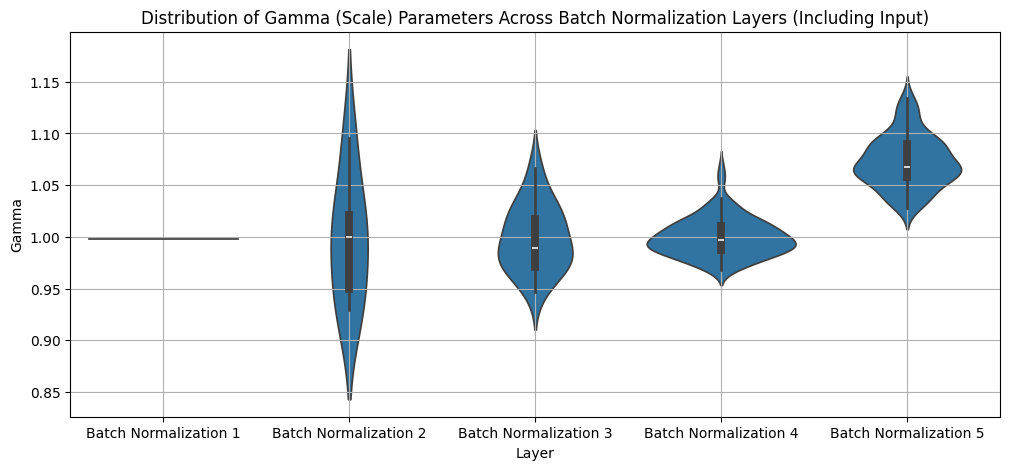

<ipython-input-37-cdad064fd319>:15: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_beta = pd.concat([df_beta, pd.DataFrame({'Layer': [f'Batch Normalization {i+1}'] * len(b), 'Beta': b})])


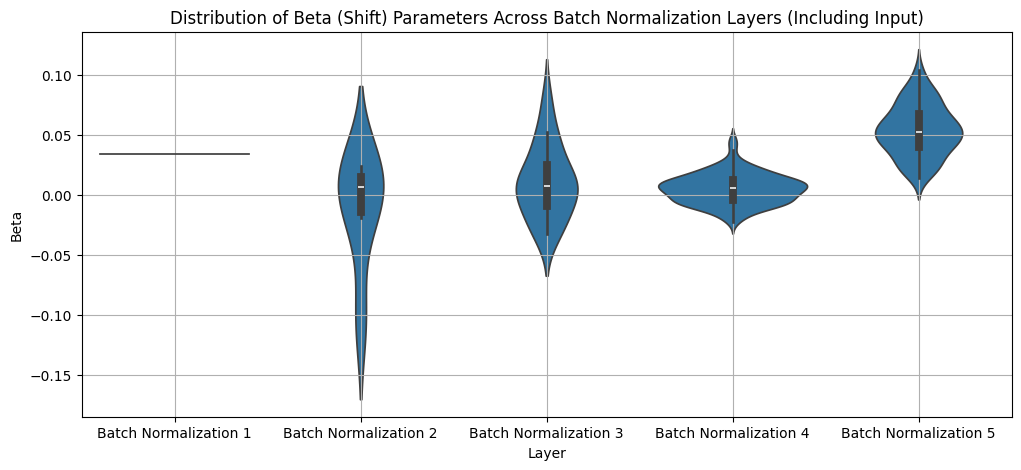

In [37]:
# gamma plot
df_gamma = pd.DataFrame({'Layer': [], 'Gamma': []})
for i, g in enumerate(gamma_vals_bn):
    df_gamma = pd.concat([df_gamma, pd.DataFrame({'Layer': [f'Batch Normalization {i+1}'] * len(g), 'Gamma': g})])

plt.figure(figsize=(12, 5))
sns.violinplot(x='Layer', y='Gamma', data=df_gamma)
plt.title("Distribution of Gamma (Scale) Parameters Across Batch Normalization Layers (Including Input)")
plt.grid(True)
plt.show()

# beta plot
df_beta = pd.DataFrame({'Layer': [], 'Beta': []})
for i, b in enumerate(beta_vals_bn):
    df_beta = pd.concat([df_beta, pd.DataFrame({'Layer': [f'Batch Normalization {i+1}'] * len(b), 'Beta': b})])

plt.figure(figsize=(12, 5))
sns.violinplot(x='Layer', y='Beta', data=df_beta)
plt.title("Distribution of Beta (Shift) Parameters Across Batch Normalization Layers (Including Input)")
plt.grid(True)
plt.show()

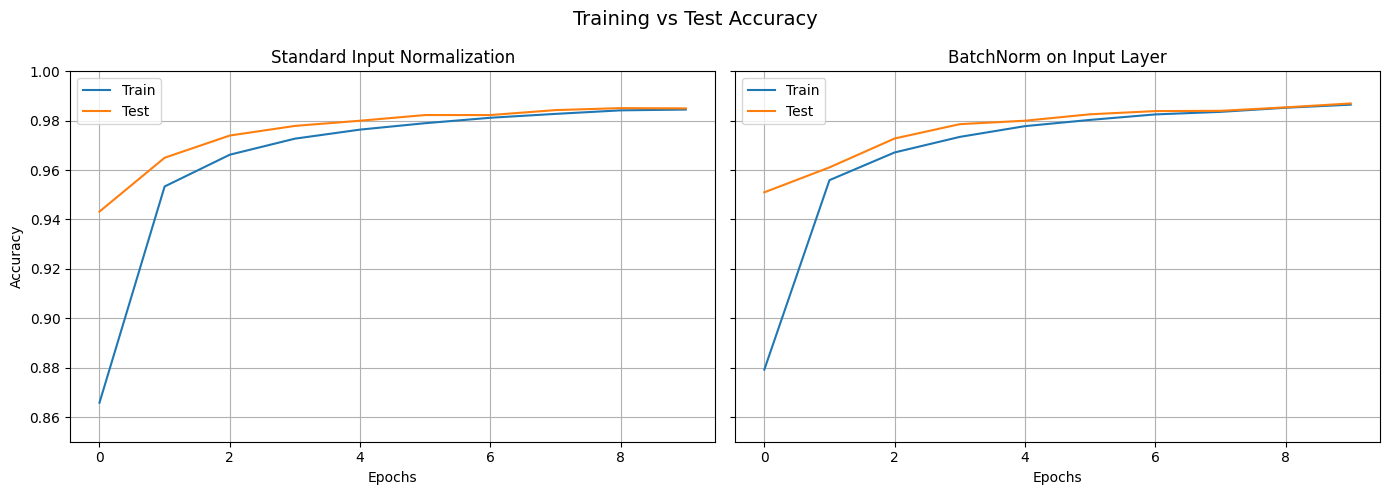

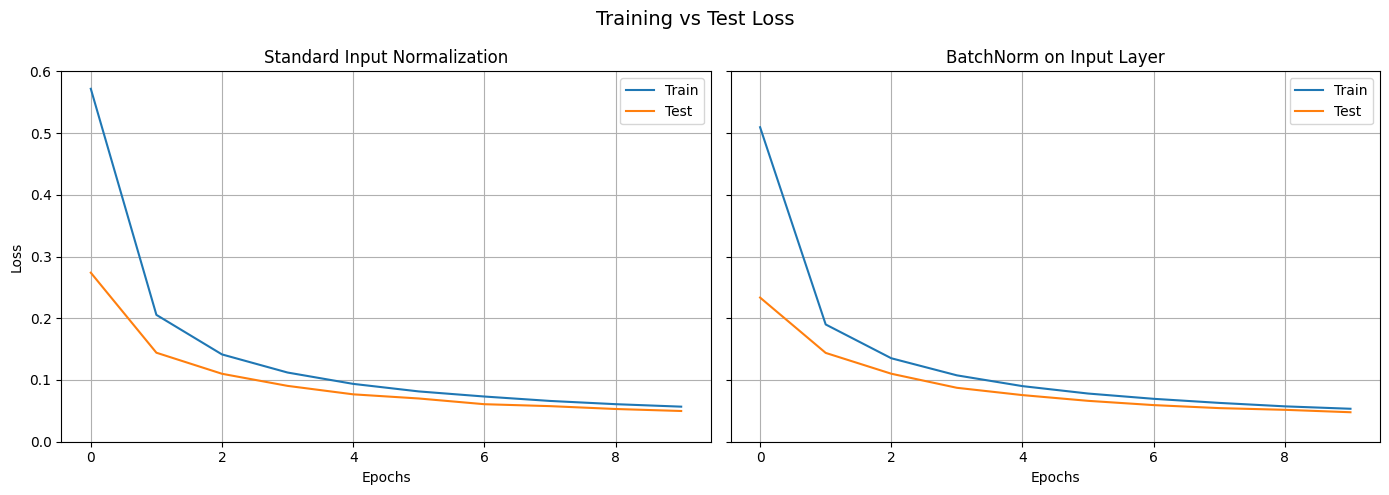

In [42]:
import matplotlib.pyplot as plt

# accuracy comparison plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)
axes[0].plot(history_std_input.history['accuracy'], label='Train')
axes[0].plot(history_std_input.history['val_accuracy'], label='Test')
axes[0].set_title("Standard Input Normalization")
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Accuracy")
axes[0].legend()
axes[0].grid(True)

axes[1].plot(history_bn_input.history['accuracy'], label='Train')
axes[1].plot(history_bn_input.history['val_accuracy'], label='Test')
axes[1].set_title("BatchNorm on Input Layer")
axes[1].set_xlabel("Epochs")
axes[1].legend()
axes[1].grid(True)


# force same y-axis limits for fair comparison
axes[0].set_ylim(0.85, 1.0)
axes[1].set_ylim(0.85, 1.0)

plt.suptitle("Training vs Test Accuracy", fontsize=14)
plt.tight_layout()
plt.show()

# loss comparison plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)
axes[0].plot(history_std_input.history['loss'], label='Train')
axes[0].plot(history_std_input.history['val_loss'], label='Test')
axes[0].set_title("Standard Input Normalization")
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Loss")
axes[0].legend()
axes[0].grid(True)

axes[1].plot(history_bn_input.history['loss'], label='Train')
axes[1].plot(history_bn_input.history['val_loss'], label='Test')
axes[1].set_title("BatchNorm on Input Layer")
axes[1].set_xlabel("Epochs")
axes[1].legend()
axes[1].grid(True)

# force same y-axis limits
axes[0].set_ylim(0.0, 0.6)
axes[1].set_ylim(0.0, 0.6)

plt.suptitle("Training vs Test Loss", fontsize=14)
plt.tight_layout()
plt.show()


Based on the plots above, it seems like batch normalization for the input layer led to a modest improvement in performance compared to standard normalization. From the accuracy plots, we can see that both training and test accuracy converge slightly faster and reach marginally higher values when batch normalization is applied to the input layer. Similarly, the loss plots show that the model with batch normalization on the input layer achieves lower training and validation losses more consistently. These results suggest that applying batch normalization at the input layer can help stabilize and slightly accelerate learning, although the overall performance improvement is relatively small.

### Question 4

In [43]:
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import SGD

# building LeNet-5 model with dropout
def build_lenet5_with_dropout():
    model = Sequential()

    # input dropout
    model.add(Dropout(0.2, input_shape=(28, 28, 1)))

    # first convolution block
    model.add(Conv2D(6, kernel_size=(5, 5), padding='same'))
    model.add(Activation('relu'))
    model.add(AveragePooling2D(pool_size=(2, 2)))

    # second convolution block
    model.add(Conv2D(16, kernel_size=(5, 5), padding='valid'))
    model.add(Activation('relu'))
    model.add(AveragePooling2D(pool_size=(2, 2)))

    # fully connected layers with dropout
    model.add(Flatten())
    model.add(Dense(120))
    model.add(Dropout(0.5))
    model.add(Activation('relu'))

    model.add(Dense(84))
    model.add(Dropout(0.5))
    model.add(Activation('relu'))

    model.add(Dense(10, activation='softmax'))

    return model

In [44]:
# instantiate and compile model
model_dropout = build_lenet5_with_dropout()
model_dropout.compile(optimizer=SGD(), loss='categorical_crossentropy', metrics=['accuracy'])

# training the model
history_dropout = model_dropout.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=10,
    batch_size=128
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/regularization/dropout.py:42: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 37s 78ms/step - accuracy: 0.2175 - loss: 2.1409 - val_accuracy: 0.8353 - val_loss: 0.7665
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 39s 73ms/step - accuracy: 0.6415 - loss: 1.0743 - val_accuracy: 0.9232 - val_loss: 0.3160
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 33s 70ms/step - accuracy: 0.7890 - loss: 0.6554 - val_accuracy: 0.9404 - val_loss: 0.2189
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 43s 75ms/step - accuracy: 0.8473 - loss: 0.4990 - val_accuracy: 0.9487 - val_loss: 0.1775
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 33s 71ms/step - accuracy: 0.8769 - loss: 0.4115 - val_accuracy: 0.9561 - val_loss: 0.1492
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 38s 82ms/step - accuracy: 0.8935 - loss: 0.3638 - val_accuracy: 0.9601 - val_loss: 0.1375
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 40s 79ms/step - accuracy: 0.9071 - loss: 0.3265 - val_accuracy: 0.9646 - val_loss: 0.1200
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 38s 72ms/step - accuracy: 0.9139 - loss: 0.2988 - 

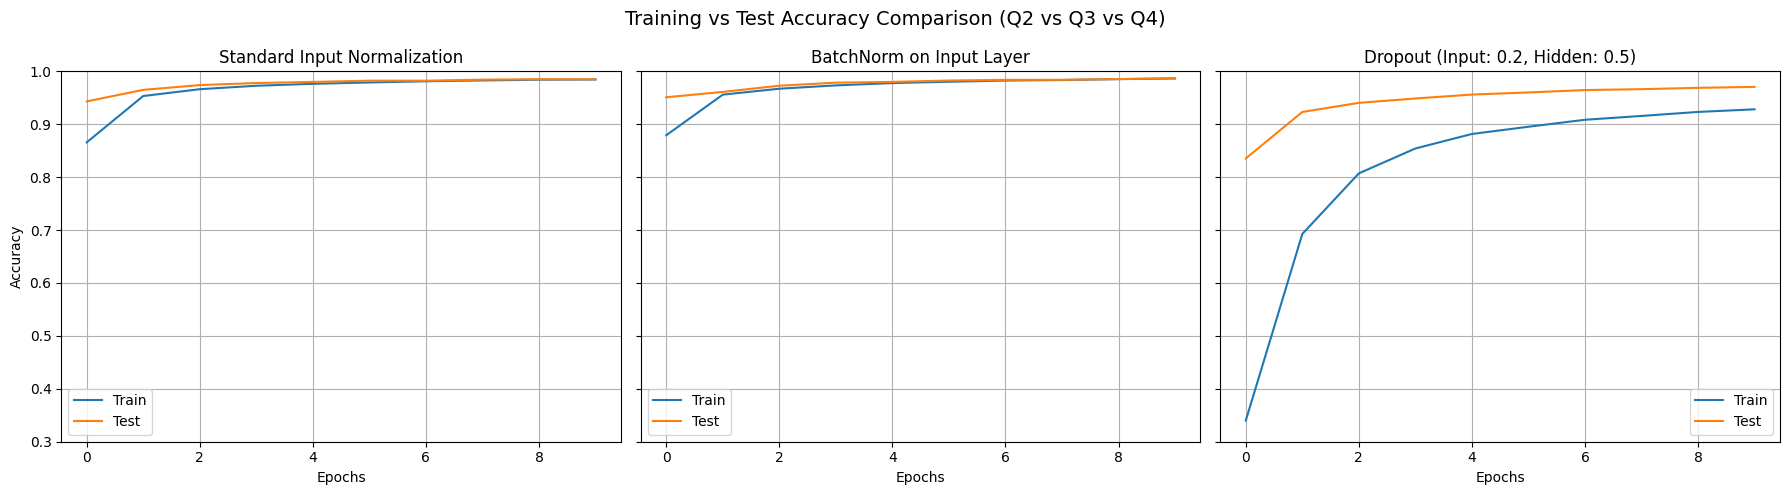

In [50]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

# Q2
axes[0].plot(history_std_input.history['accuracy'], label='Train')
axes[0].plot(history_std_input.history['val_accuracy'], label='Test')
axes[0].set_title('Standard Input Normalization')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True)

# Q3
axes[1].plot(history_bn_input.history['accuracy'], label='Train')
axes[1].plot(history_bn_input.history['val_accuracy'], label='Test')
axes[1].set_title('BatchNorm on Input Layer')
axes[1].set_xlabel('Epochs')
axes[1].legend()
axes[1].grid(True)

# Q4
axes[2].plot(history_dropout.history['accuracy'], label='Train')
axes[2].plot(history_dropout.history['val_accuracy'], label='Test')
axes[2].set_title('Dropout (Input: 0.2, Hidden: 0.5)')
axes[2].set_xlabel('Epochs')
axes[2].legend()
axes[2].grid(True)

# ensure same Y scale across all subplots
for ax in axes:
    ax.set_ylim(0.3, 1.0)

plt.suptitle('Training vs Test Accuracy Comparison (Q2 vs Q3 vs Q4)', fontsize=14)
plt.tight_layout()
plt.show()


Compared to the models using batch normalization (Questions 2 and 3), the dropout model showed noticeably lower training accuracy and slightly lower test accuracy. While dropout did reduce overfitting to some extent (which is shown by the smaller gap between training and test accuracy) it also led to overall reduced performance. I think this would be expected, as dropout introduces noise during training to improve generalization, but in this case, it seems to have been less effective than batch normalization.

In conclusion, dropout did not improve performance relative to batch normalization for this setup. Batch normalization provided both faster convergence and higher accuracy on the test set in this case.

### Question 5

In [51]:
def build_lenet5_with_bn_and_dropout():
    model = Sequential()
    model.add(BatchNormalization(input_shape=(28, 28, 1)))
    model.add(Dropout(0.2))  # input dropout
    model.add(Conv2D(6, kernel_size=(5, 5), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(AveragePooling2D(pool_size=(2, 2)))

    model.add(Conv2D(16, kernel_size=(5, 5), padding='valid'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(AveragePooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(120))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))  # hidden dropout
    model.add(Activation('relu'))

    model.add(Dense(84))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))  # hidden dropout
    model.add(Activation('relu'))

    model.add(Dense(10, activation='softmax'))
    return model

In [52]:
model_bn_dropout = build_lenet5_with_bn_and_dropout()
model_bn_dropout.compile(optimizer=tf.keras.optimizers.SGD(),
                         loss='categorical_crossentropy',
                         metrics=['accuracy'])

history_bn_dropout = model_bn_dropout.fit(x_train, y_train,
                                          validation_data=(x_test, y_test),
                                          epochs=10,
                                          batch_size=128)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/normalization/batch_normalization.py:142: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 57s 114ms/step - accuracy: 0.4205 - loss: 1.7782 - val_accuracy: 0.8943 - val_loss: 0.5094
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 81s 112ms/step - accuracy: 0.7756 - loss: 0.7559 - val_accuracy: 0.9343 - val_loss: 0.2792
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 52s 111ms/step - accuracy: 0.8458 - loss: 0.5451 - val_accuracy: 0.9520 - val_loss: 0.1931
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 82s 110ms/step - accuracy: 0.8755 - loss: 0.4397 - val_accuracy: 0.9565 - val_loss: 0.1668
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 83s 112ms/step - accuracy: 0.8950 - loss: 0.3755 - val_accuracy: 0.9633 - val_loss: 0.1364
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 81s 110ms/step - accuracy: 0.9076 - loss: 0.3266 - val_accuracy: 0.9673 - val_loss: 0.1194
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 83s 112ms/step - accuracy: 0.9207 - loss: 0.2871 - val_accuracy: 0.9693 - val_loss: 0.1098
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 52s 110ms/step - accuracy: 0.9288 - loss: 0

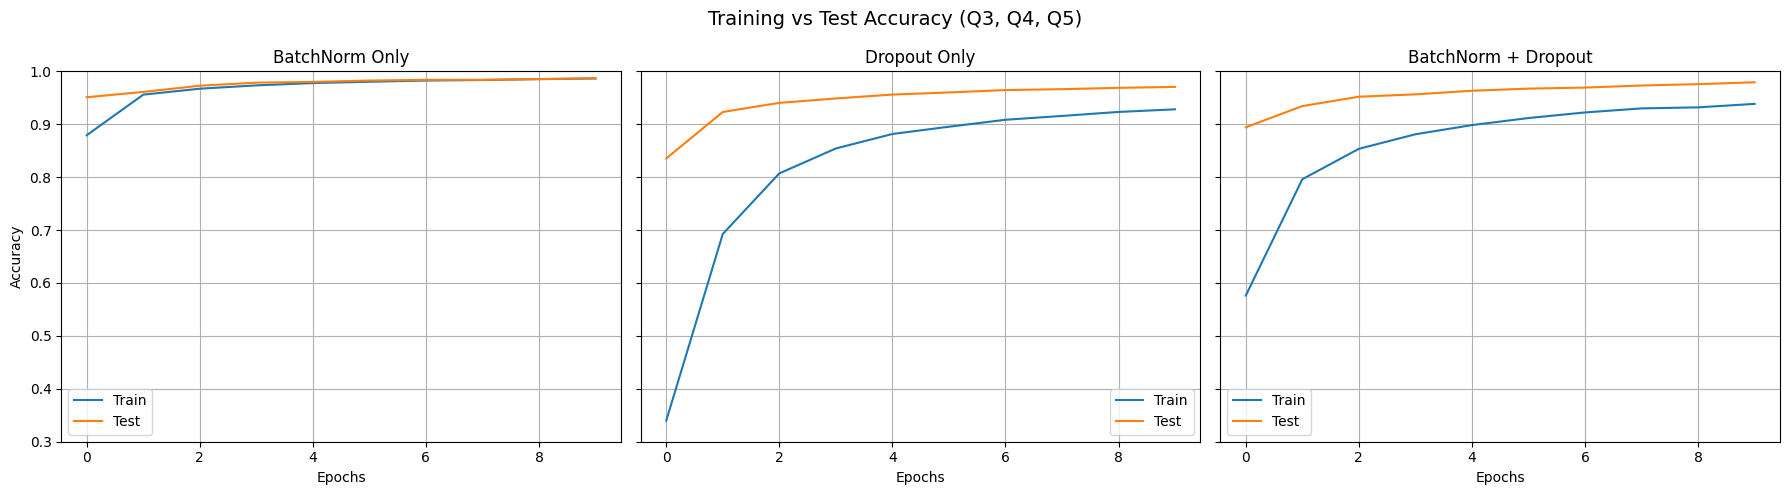

In [57]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

# Q3 - BatchNorm only
axes[0].plot(history_bn_input.history['accuracy'], label='Train')
axes[0].plot(history_bn_input.history['val_accuracy'], label='Test')
axes[0].set_title("BatchNorm Only")
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Accuracy")
axes[0].legend()
axes[0].grid(True)

# Q4 - Dropout only
axes[1].plot(history_dropout.history['accuracy'], label='Train')
axes[1].plot(history_dropout.history['val_accuracy'], label='Test')
axes[1].set_title("Dropout Only")
axes[1].set_xlabel("Epochs")
axes[1].legend()
axes[1].grid(True)

# Q5 - BatchNorm + Dropout
axes[2].plot(history_bn_dropout.history['accuracy'], label='Train')
axes[2].plot(history_bn_dropout.history['val_accuracy'], label='Test')
axes[2].set_title("BatchNorm + Dropout")
axes[2].set_xlabel("Epochs")
axes[2].legend()
axes[2].grid(True)

# matching y-axis
for ax in axes:
    ax.set_ylim(0.3, 1.0)

plt.suptitle("Training vs Test Accuracy (Q3, Q4, Q5)", fontsize=14)
plt.tight_layout()
plt.show()


Adding both Batch Normalization and Dropout provides a balance between the strong generalization of Dropout and the training stability of BatchNorm.

Based on the plots above, we can see that BatchNorm Only achieves the highest training accuracy and slightly better test performance. However, it may be prone to overfitting since there's no regularization.

Dropout Only helps reduce overfitting (as shown by larger gap between training test accuracy), but also significantly slows training, so accuracy improves more slowly.

BatchNorm + Dropout offers a good compromise. It improves training speed and maintains strong generalization, closing the performance gap between training and test accuracy better than either method alone.

Thus, combining BatchNorm and Dropout improves robustness and generalization over Dropout alone, though in this case, BatchNorm alone slightly outperforms the combination in pure accuracy. However, the combined setup is more likely to generalize well across different training conditions.